In [12]:
!pip install pandas seaborn matplotlib scikit-learn gensim eli5 tiktoken spacy gensim wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.1/520.1 kB 7.3 MB/s eta 0:00:00a 0:00:01


In [6]:
import tiktoken
import pandas as pd
from nltk.tokenize import word_tokenize, sent_tokenize
import numpy
import matplotlib.pyplot as plt
from datasets import load_dataset

## Dataset loading

In [7]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/florinekieraga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/florinekieraga/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
dataset = load_dataset("yaful/DeepfakeTextDetect")
df = dataset["train"].to_pandas()
df.head()

,text,label,src
0,White girls very rarely date Asian men. Even i...,1,cmv_human
1,I am a 23 year old male Indian American male. ...,1,cmv_human
2,"Take three people, Persons A, B, and C. They l...",1,cmv_human
3,(A) Work part-time in high school; Then go to ...,1,cmv_human
4,When police introduce a new form of speed prev...,1,cmv_human


Text(0.5, 1.0, 'Data Distribution')

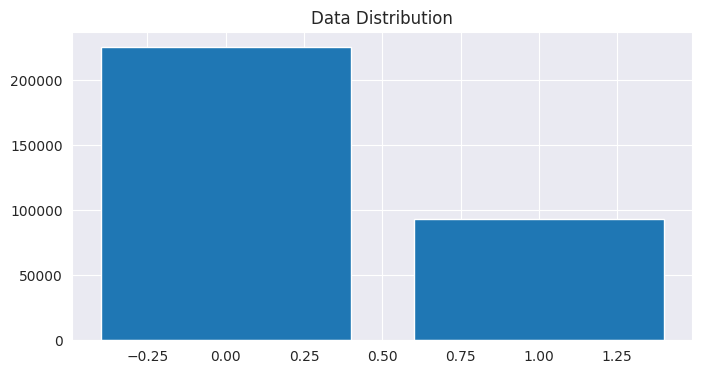

In [10]:
val_count = df.label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Data Distribution")

Normalisation

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize=(20,20))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(df[df.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

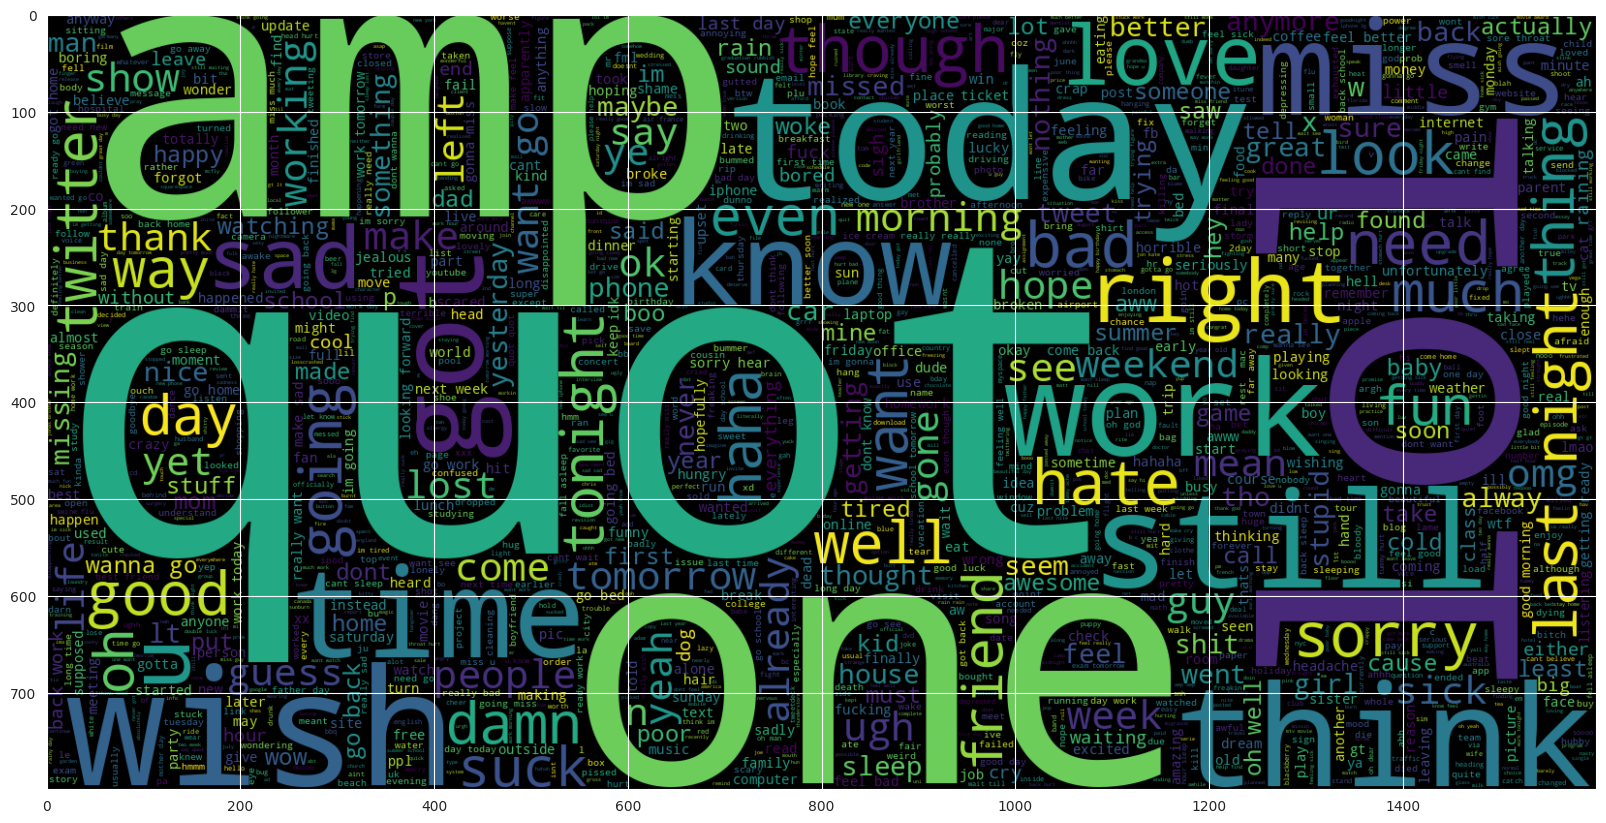

In [14]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

## Fonction de création de tokens

In [15]:
def lemma_tokenize(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(t) for t in word_tokenize(doc)]

def byte_pair_tokenize(doc):
    enc = tiktoken.encoding_for_model("gpt-4")
    tokens = enc.encode(doc)
    return [str(token) for token in tokens]

## Training Word2Vec and tf-idf 

In [32]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight



In [33]:
X_list = list(df.text)
X_strings = " ".join(X_list)
X_sents = sent_tokenize(X_strings)
X_sents = [word_tokenize(s) for s in X_sents]

In [34]:
model = Word2Vec(sentences=X_sents, vector_size=50, window=5, min_count=5, workers=4)

word_vectors = model.wv
word_vectors.save("word2vec.wordvectors")
del model

mv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

In [35]:
print(mv.get_vecattr)


<bound method KeyedVectors.get_vecattr of <gensim.models.keyedvectors.KeyedVectors object at 0x71b6e566c790>>


In [36]:
import numpy as np
def document_vector(doc, wv):
    words = word_tokenize(doc)
    word_vectors = np.array([wv[word] for word in words if word in wv])
    
    if len(word_vectors) == 0:
        return np.zeros(wv.vector_size)
    return np.mean(word_vectors, axis=0)

In [37]:
X = np.array([document_vector(text, mv) for text in df.text])

X_train, X_test, y_train, y_test = train_test_split(df.text, df.polarity, test_size=0.2, random_state=42)
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

print(f"Features dimension: {X_train.shape}")

Features dimension: (1280000,)
